In [1]:
import pandas as pd

import numpy as np
from scipy import stats
from math import ceil
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [7]:

print(train_df.shape) # 1460,81
print(test_df.shape) # 1459,80

(1460, 81)
(1459, 80)


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [11]:
#checking all non-numerical columns
for c in train_df.columns:
    col_type = train_df[c].dtype
    if col_type != 'int64' and col_type != 'float64':
        print(c)

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


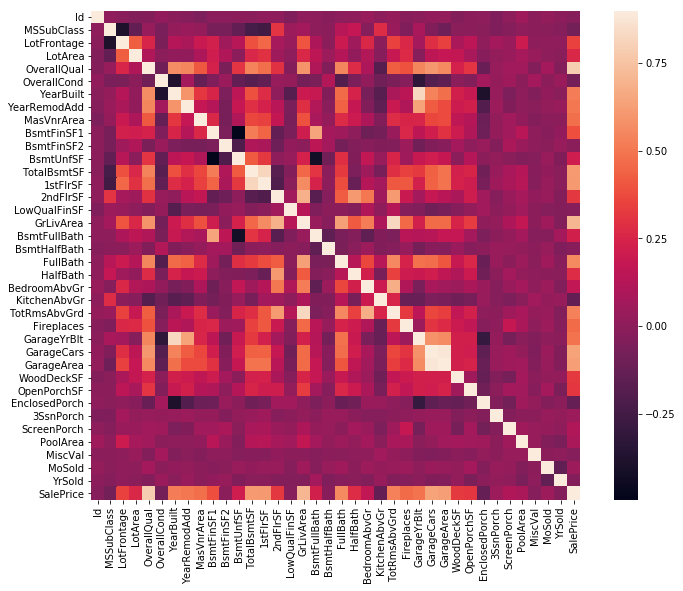

In [15]:
# Plot the Correlation map to see how features are correlated with target: SalePrice
corr_matrix = train_df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corr_matrix, vmax=0.90, square=True)

Let us do some feature selection on the basis of the correlations above and some general understanding of the problem:

1) If we look at the heatmap above, all white squares indicate high correlation between the corresponding variables

2) 'GarageCars' and 'GarageArea' show high correlation and is aligned with our intuitive thinking as well. More the area of the Garage , more the number of cars. Furthermore, both seem to have a similar (and relatively high) correlation with 'SalePrice'. This shows a clear case of multicollinearity. Thus we can remove one of them and retain the other.

3) Furthermore, 'TotalBsmtSF' and '1stFlrSF' show high correlation again indicating multicollinearity. We should thus remove one of these.

4) If we look at the correlation between 'TotalBsmtSF' and 'SalePrice', we see a white square i.e. high correlation. This indicates that TotalBsmtSF should be retained as it can help with the SalePrice prediction

5) Another set of variables that show high correlation are 'YearBuilt' and 'GarageYrBlt'. Let us look at two other aspects: percentage of missing values in 'GarageYrBlt' and the correlation between 'YearBuilt' and 'SalePrice'. 'GarageYrBlt' has over a 5% missing values. Also, 'YearBuilt' seems to have a decent (around 0.5) correlation with 'SalePrice'. It seems like we should retain 'YearBuilt' and let go of 'GarageYrBlt'

6) Also, besides 'YearBuilt', ( one of 'GarageCars' or 'GarageArea') and 'TotalBsmtSF', we should keep in mind four other variables that seem to have good correlation with 'SalePrice': 'OverallQual', 'GrLivArea', 'FullBath' and 'TotRmsAbvGrd'

7) However, if we look at the correlation of 'TotRmsAbvGrd' with other variables, we see a high correlation with 'GrLivArea'. To be able to make a call on which variable to remove, let us look at some more analysis.

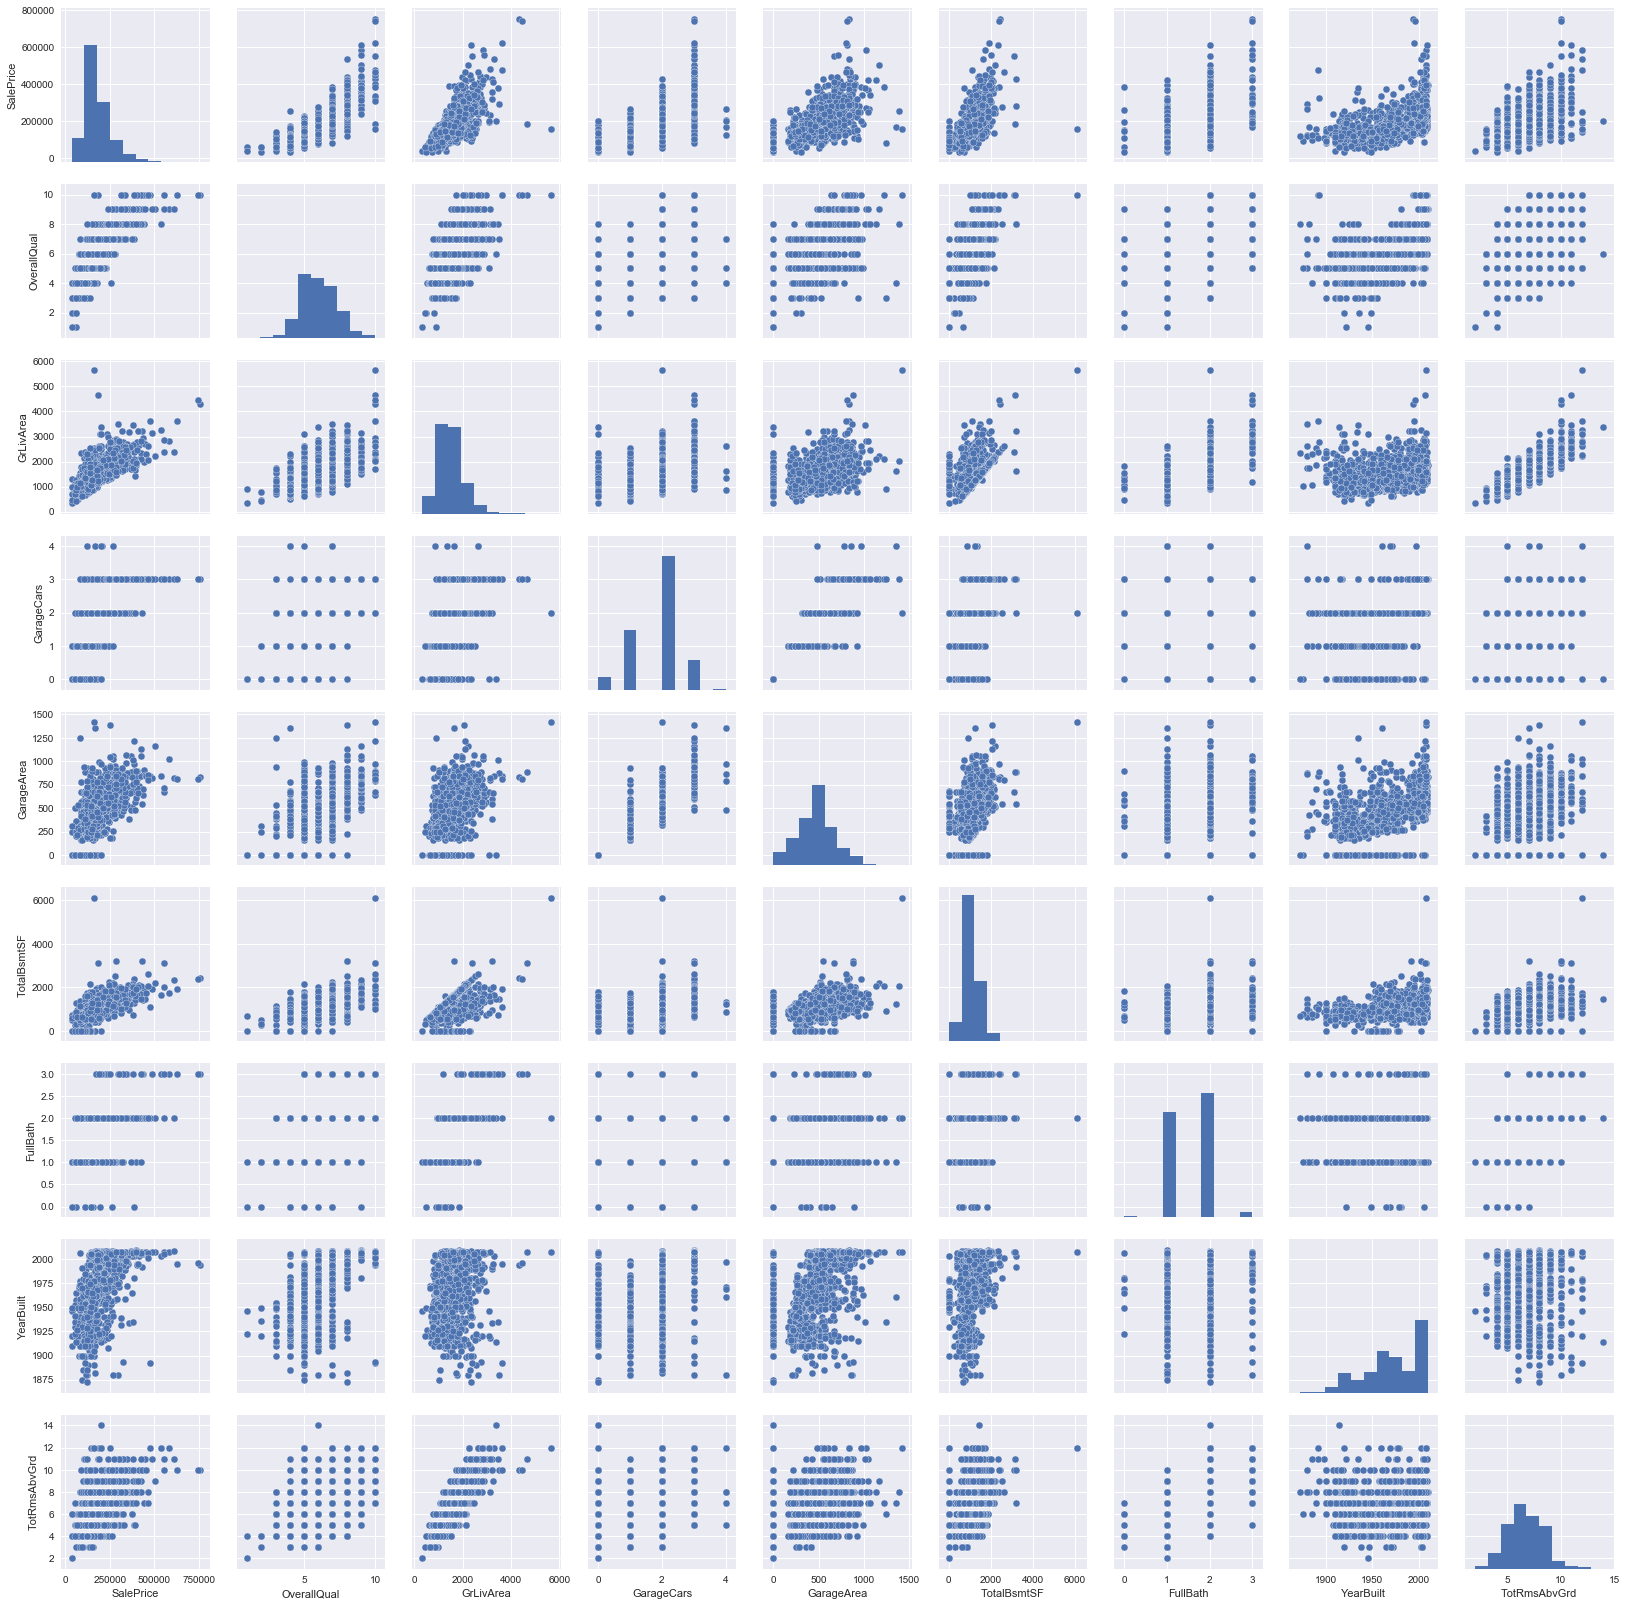

In [16]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars','GarageArea' ,'TotalBsmtSF', 'FullBath', 'YearBuilt','TotRmsAbvGrd']
sns.pairplot(train_df[cols], size = 2.5)
plt.show();

Following are the major observations from here:

1) GrLivArea and TotRmsAbvGrd show high linear relationship.

2) Let us shift focus to GrLivArea and TotalBsmtSF show a linear relationship with almost a boundary defining the plot. This basically indicates that GrLivArea defined the higher limit for the TotalBsmtSF (Basement area). Not many houses will have basements larger than the ground floor living area.

3) 'SalePrice' shows almost a steep increase with 'YearBuilt', basically indicating that prices increase (almost eponentially) as the houses decrease in age. Most recent houses are highly priced.

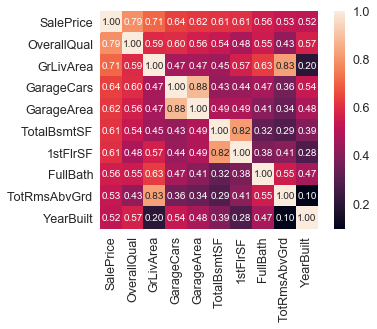

In [17]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Thus final list of variables to be definitely considered and variables to be excluded:

1) Variable with highest correlation with 'SalePrice' is 'OverallQual'-----> Retain 'OverallQual'

2) High correlation between 'GarageCars' and 'GarageArea' + High correlation between 'GarageCars' and 'SalePrice' ----> Keep 'GarageCars'; remove 'GarageArea'

3) 'TotalBsmtSF' and '1stFlrSF' have high correlation and are equally correlated with 'SalePrice'-----> Randomly selecting 'TotalBsmtSF', remove '1stFlrSF'

4) Of 'GarageYrBlt' and 'YearBuilt', 'YearBuilt' has lower missing values and higher correlation with 'SalePrice'-----> retain 'YearBuilt', remove 'GarageYrBlt'

5) Strong correlation between 'TotRmsAbvGrd' and 'GrLivArea' + higher correlation between 'GrLivArea' and 'SalePrice'-------> Keep 'GrLivArea' ; remove 'TotRmsAbvGrd'

6) Retain 'FullBath' as we did not see correlation with any other variable but it has a significant association with 'SalePrice'

#### Outlier Removal
 
##### Let us first look at outliers in the numerical variables with the highest correlation to 'SalePrice'. Those are the ones that should make the most difference to 'SalePrice' predictions.

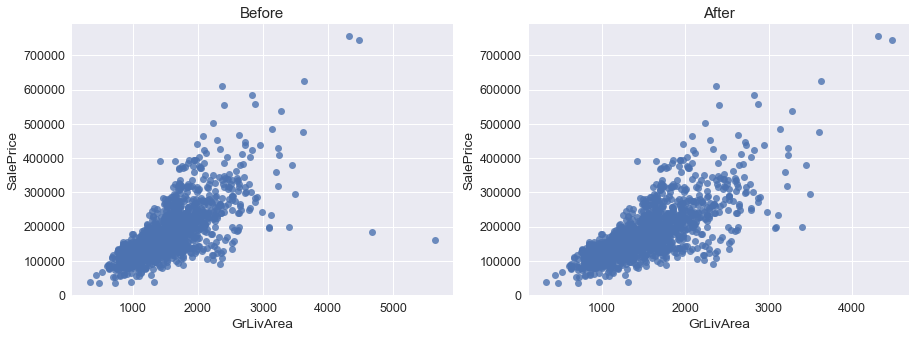

In [18]:
# first variable : GrLivArea
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train_df['GrLivArea'], y=train_df['SalePrice'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)
g = sns.regplot(x=train_df['GrLivArea'], y=train_df['SalePrice'], fit_reg=False).set_title("After")

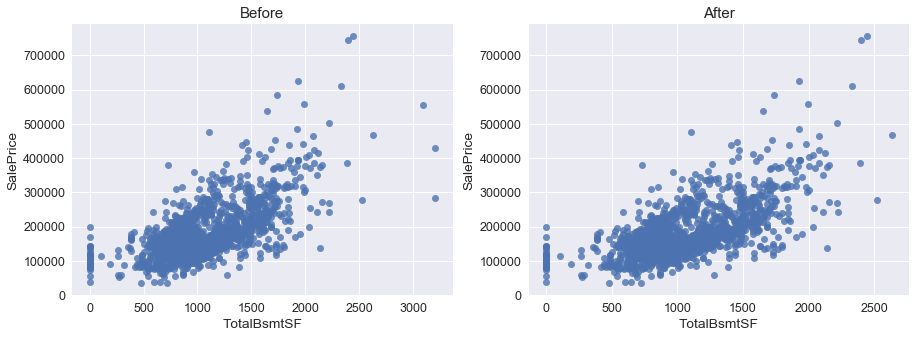

In [19]:
# Next Up: TotalBsmtSF
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train_df['TotalBsmtSF'], y=train_df['SalePrice'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train_df = train_df.drop(train_df[(train_df['TotalBsmtSF']>3000)].index)
g = sns.regplot(x=train_df['TotalBsmtSF'], y=train_df['SalePrice'], fit_reg=False).set_title("After")

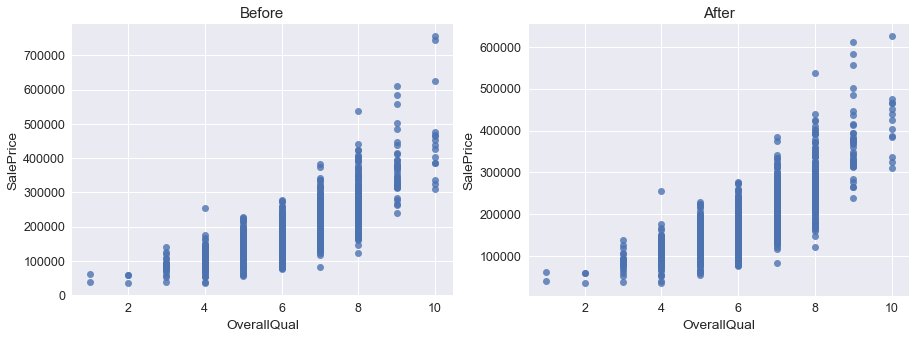

In [20]:
# Next Up : OverallQual
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train_df['OverallQual'], y=train_df['SalePrice'], fit_reg=False).set_title("Before")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train_df = train_df.drop(train_df[(train_df['OverallQual']>9) & (train_df['SalePrice']>700000)].index)
g = sns.regplot(x=train_df['OverallQual'], y=train_df['SalePrice'], fit_reg=False).set_title("After")

In [21]:
train_df.shape # 1453,81
# 7 rows deleted

(1453, 81)

In [22]:
#check if there are columns that are present in train and not in test
# if there are any, we will have to drop them from train

extra_train_cols = set( train_df.columns ) - set( test_df.columns )
extra_train_cols # no columns that are present in train and not in test

{'SalePrice'}

#### Investigation of Target Variable
What are we doing?

We are investigating the nature of the target or response variable here; i.e. 'SalePrice'. On the basis of our findings here, we can transform the variable.

Why are we doing this?
This is to ensure the model predictions behave better. What this means is, in regression it is necessary that the residuals follow a normal distribution. Now, if the predicted values are normally distributed then the residuals are as well and vice versa.

In [23]:
# basic states of 'SalePrice'
train_df['SalePrice'].describe()
# here we see min= 34900 and max= 625000
# to get a better understanding, we will plot a distribution curve

count      1453.000000
mean     179649.825189
std       75809.490820
min       34900.000000
25%      129900.000000
50%      162900.000000
75%      213500.000000
max      625000.000000
Name: SalePrice, dtype: float64

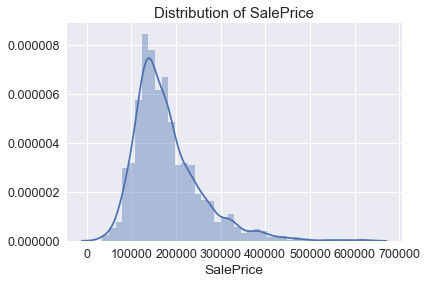

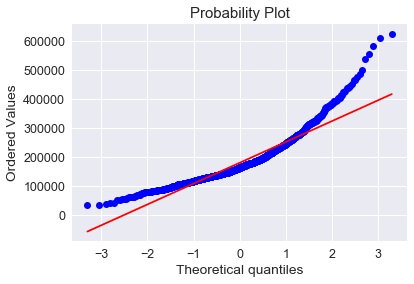

In [24]:
#distribution plot- histogram
sns.distplot(train_df['SalePrice']).set_title("Distribution of SalePrice")

# probability plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)

We see a positive skewness. This is not exactly a normal distribution. Also, the values do not follow the linear trend here.
Now, if we observe a positive or a right skewness, log transformation is a good option

Why log?
The non-linear trend shows 'SalePrice' has some sort of exponential relationship with the independent variables. Applying a log function on these values should give a linear trend and convert the set of values into 'normally distributed' values.

Furthermore, for this problem, "submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)"

All this would just make sense if we replace the values in 'SalePrice' column by the corresponding log values


 mean = 12.02 and std dev = 0.39



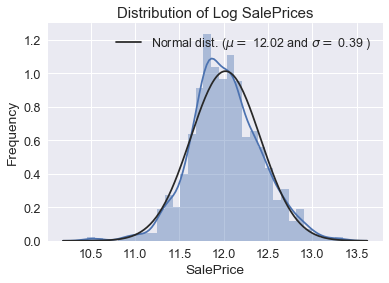

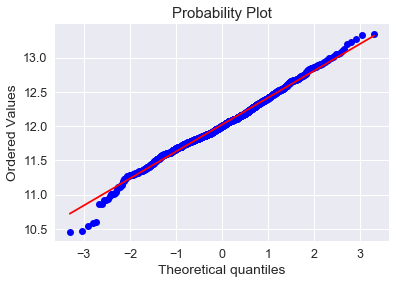

In [25]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

#Check the new distribution 
sns.distplot(train_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print( '\n mean = {:.2f} and std dev = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Distribution of Log SalePrices')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

In [26]:
# let us also store the target variable
y_train = train_df.SalePrice.values
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220


In [27]:
# Concatenating train and test to create total_df (aggregated dataset)
# store the unique ids of training dataset
train_ids = train_df.index    
# store the unique ids of test dataset
test_ids = test_df.index

# combine train and test datas in to one dataframe
total_df = pd.concat([train_df,test_df]).reset_index(drop=True)
#total_df.drop(['SalePrice'], axis=1, inplace=True)
print("Shape of total_df : {}".format(total_df.shape))
total_df.isnull().sum()

Shape of total_df : (2912, 81)


1stFlrSF            0
2ndFlrSF            0
3SsnPorch           0
Alley            2714
BedroomAbvGr        0
BldgType            0
BsmtCond           82
BsmtExposure       82
BsmtFinSF1          1
BsmtFinSF2          1
BsmtFinType1       79
BsmtFinType2       79
BsmtFullBath        2
BsmtHalfBath        2
BsmtQual           81
BsmtUnfSF           1
CentralAir          0
Condition1          0
Condition2          0
Electrical          1
EnclosedPorch       0
ExterCond           0
ExterQual           0
Exterior1st         1
Exterior2nd         1
Fence            2342
FireplaceQu      1420
Fireplaces          0
Foundation          0
FullBath            0
                 ... 
LotShape            0
LowQualFinSF        0
MSSubClass          0
MSZoning            4
MasVnrArea         23
MasVnrType         24
MiscFeature      2807
MiscVal             0
MoSold              0
Neighborhood        0
OpenPorchSF         0
OverallCond         0
OverallQual         0
PavedDrive          0
PoolArea  

In [28]:
# Creating a list of features to be removed

feature_drop1= ['GarageYrBlt','TotRmsAbvGrd'] # will remove 1stFlrSF and GarageArea later-- after creating additional features
#removing features-- with multicollinearity or low correlation with target variable
total_df.drop(feature_drop1,
              axis=1, inplace=True)
total_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SalePrice,SaleType,ScreenPorch,Street,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,12.247699,WD,0,Pave,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,12.109016,WD,0,Pave,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,12.317171,WD,0,Pave,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,11.849405,WD,0,Pave,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,12.429220,WD,0,Pave,1145.0,AllPub,192,2000,2000,2008
